In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from pathlib import PosixPath
from typing import Union, Tuple, List, Sequence
from torchvision.transforms import Compose, Resize, InterpolationMode, ToTensor, ToPILImage, Normalize
from torch import Tensor
import numpy as np
import multiprocessing as mp
import torch.nn.functional as F
import pandas as pd
from time import time
from tqdm import tqdm
import logging
from collections import OrderedDict
from matplotlib import pyplot as plt

## Importing custom modules

In [3]:
from super_image_resolution import get_root_path
from super_image_resolution.utils import (
    split, 
    make_dirs, 
    find_latest_model_version, 
    compute2d_means_and_stds, 
    load,
    dump,
    save_output)
from super_image_resolution.datasets import CustomDataset
from super_image_resolution.transforms import CustomResize, InvertNormalize
from super_image_resolution.models.unet import UNet

## Experiment configuration

In [4]:
HPARAMS = OrderedDict()

In [5]:
HPARAMS["PROJECT_PATH"] = get_root_path()
HPARAMS["ASSETS_PATH"] = os.path.join(HPARAMS["PROJECT_PATH"], "assets")
HPARAMS["DATA_PATH"] = os.path.join("/", "scratch", "mittal.nit", "faces-spring-2020")

HPARAMS["MODEL_NAME"] = "unet_l1loss_batchnorm"
HPARAMS["MODEL_PATH"] = os.path.join(HPARAMS["ASSETS_PATH"], HPARAMS["MODEL_NAME"])

In [6]:
make_dirs(HPARAMS["ASSETS_PATH"])
make_dirs(HPARAMS["MODEL_PATH"])

/home/mittal.nit/projects/super_image_resolution/assets already exists
Created path /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm


In [7]:
HPARAMS["WEIGHTS_PATH"] = os.path.join(HPARAMS["MODEL_PATH"], "weights")
HPARAMS["MODEL_WEIGHTS"] = "model"
HPARAMS["OPTIM_WEIGHTS"] = "optim"
HPARAMS["LR_SCH_WEIGHTS"] = "lr_sch"

HPARAMS["VERSION"] = find_latest_model_version(HPARAMS["MODEL_PATH"]) + 1
print(f"Current version: {HPARAMS['VERSION']}")
# HPARAMS["VERSION"] = 0
HPARAMS["EXPERIMENT_VERSION_PATH"] = os.path.join(HPARAMS["MODEL_PATH"], f"version_{HPARAMS['VERSION']}")
HPARAMS["LOG"] = "log"
HPARAMS["HPARAMS"] = "hparams"
HPARAMS["METRICS"] = "metrics"
HPARAMS["IMAGES_PATH"] = os.path.join(HPARAMS["EXPERIMENT_VERSION_PATH"], "images", "val")

Current version: 1


In [8]:
make_dirs(HPARAMS["WEIGHTS_PATH"])
make_dirs(HPARAMS["EXPERIMENT_VERSION_PATH"])
make_dirs(HPARAMS["IMAGES_PATH"])

Created path /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/weights
Created path /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1
Created path /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/images/val


In [9]:
logging.basicConfig(
    filename=os.path.join(HPARAMS["EXPERIMENT_VERSION_PATH"], HPARAMS["LOG"]),
    format='%(asctime)s %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    encoding='utf-8', 
    level=logging.INFO)

In [10]:
HPARAMS["SPLIT_RATIOS"] = (.85, .10, .05)
HPARAMS["RANDOM_SEED"] = 40

HPARAMS["TRAIN_BATCH_SIZE"] = 64
HPARAMS["VAL_BATCH_SIZE"] = 128
HPARAMS["TEST_BATCH_SIZE"] = 128
HPARAMS["NUM_WORKERS"] = max(0, (mp.cpu_count() - 7) // 3)

HPARAMS["PRE_TRAINED"] = True
HPARAMS["IN_CHANNELS"] = 3
HPARAMS["OUT_CHANNELS"] = 3
HPARAMS["ACTIVATION"] = "lrelu"
HPARAMS["NORM"] = "batchnorm"
HPARAMS["DEVICE"] = "cuda" if torch.cuda.is_available() else "cpu"
# HPARAMS["DEVICE"] = "cpu"

HPARAMS["DATA_IN_NORM"] = {
    "means": [0.5351, 0.4395, 0.3800],
    "stds": [0.2339, 0.2071, 0.2065]}

HPARAMS["DATA_OUT_NORM"] = {
    "means": [0.5345, 0.4390, 0.3796], 
    "stds": [0.2353, 0.2083, 0.2074]}
HPARAMS["SCALE_Y"] = 2.3

HPARAMS["EPOCHS"] = 50
HPARAMS["LR"] = 1e-3
HPARAMS["BETAS"] = (.5, .9)
 
HPARAMS["LR_STEP_SIZE"] = 10
HPARAMS["LR_GAMMA"] = .999

HPARAMS["INBETWEEN_SAVE_METRICS_INTERVAL"] = 25
HPARAMS["MAX_VAL_SAVE_SAMPLES"] = min(5, HPARAMS["VAL_BATCH_SIZE"])
HPARAMS["VAL_RANDOM_SAVE_SAMPLES"] = True

## Initializing transformations

In [11]:
logging.info("Defininig transformations")
in_transforms = Compose([
    CustomResize(size=64, interpolation=InterpolationMode.BICUBIC), 
    CustomResize(size=128, interpolation=InterpolationMode.BICUBIC), 
    ToTensor(), 
    Normalize(mean=HPARAMS["DATA_IN_NORM"]["means"], std=HPARAMS["DATA_IN_NORM"]["stds"])
])
    
out_transforms = Compose([
    Resize(size=128, interpolation=InterpolationMode.BICUBIC), 
    ToTensor(),
    Normalize(mean=HPARAMS["DATA_OUT_NORM"]["means"], std=HPARAMS["DATA_OUT_NORM"]["stds"])
])

In [12]:
logging.info("Splitting data into train, val and test set")
train, val, test = split(
    path=HPARAMS["DATA_PATH"], 
    ratios=HPARAMS["SPLIT_RATIOS"],
    seed=HPARAMS["RANDOM_SEED"])

HPARAMS["NUM_TRAIN_SAMPLES"] = len(train)
HPARAMS["NUM_VAL_SAMPLES"] = len(val)
HPARAMS["NUM_TEST_SAMPLES"] = len(test)

## Initializing Datasets

In [13]:
logging.info("Initializing datasets")
train_dataset = CustomDataset(
    paths=train, in_transforms=in_transforms, out_transforms=out_transforms)

val_dataset = CustomDataset(
    paths=val, in_transforms=in_transforms, out_transforms=out_transforms)

test_dataset = CustomDataset(
    paths=test, in_transforms=in_transforms, out_transforms=out_transforms)

## Initializing Dataloaders

In [14]:
# train_loader = DataLoader(
#     dataset=train_dataset, 
#     batch_size=HPARAMS["TRAIN_BATCH_SIZE"],
#     shuffle=True, 
#     num_workers=12)

In [15]:
# i, o = next(iter(train_loader))
# i.shape, i.min(), i.max(), o.min(), o.max()

In [16]:
# ToPILImage()(i[0])

In [17]:
# ToPILImage()(o[0])

In [18]:
# (means_in, stds_in), (means_out, stds_out) = compute2d_means_and_stds(num_channels=3, data_loader=train_loader)
# (means_in, stds_in), (means_out, stds_out)

In [19]:
logging.info("Initializing data loaders")
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=HPARAMS["TRAIN_BATCH_SIZE"],
    shuffle=True, 
    num_workers=HPARAMS["NUM_WORKERS"])

val_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=HPARAMS["VAL_BATCH_SIZE"],
    shuffle=False,
    num_workers=HPARAMS["NUM_WORKERS"])

test_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=HPARAMS["TEST_BATCH_SIZE"],
    shuffle=False, 
    num_workers=HPARAMS["NUM_WORKERS"])

In [20]:
HPARAMS["NUM_TRAIN_BATCHES"] = len(train_loader)
HPARAMS["NUM_VAL_BATCHES"] = len(val_loader)
HPARAMS["NUM_TEST_BATCHES"] = len(test_loader)

HPARAMS["INBETWEEN_TRAIN_VAL_CHECK_INTERVAL"] = min(25, HPARAMS["NUM_TRAIN_BATCHES"])

In [21]:
i, o = next(iter(train_loader))
i.shape, i.min(), i.max(), o.min(), o.max()

(torch.Size([64, 3, 128, 128]),
 tensor(-2.2877),
 tensor(3.0024),
 tensor(-2.2716),
 tensor(2.9913))

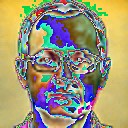

In [22]:
ToPILImage()(i[0])

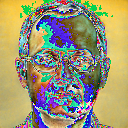

In [23]:
ToPILImage()(o[0])

In [24]:
in_invert_norm = InvertNormalize(
    num_channels=3,
    mean=torch.tensor(HPARAMS["DATA_IN_NORM"]["means"]),
    std=torch.tensor(HPARAMS["DATA_IN_NORM"]["stds"]))

out_invert_norm = InvertNormalize(
    num_channels=3,
    mean=torch.tensor(HPARAMS["DATA_OUT_NORM"]["means"]),
    std=torch.tensor(HPARAMS["DATA_OUT_NORM"]["stds"]))

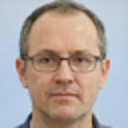

In [25]:
ToPILImage()(in_invert_norm(i[0])[0])

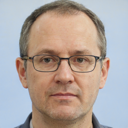

In [26]:
ToPILImage()(out_invert_norm(o[0])[0])

## Initiating model

In [27]:
logging.info("Initializing model")
model = UNet(
    in_channels=HPARAMS["IN_CHANNELS"], 
    out_channels=HPARAMS["OUT_CHANNELS"],
    norm=HPARAMS["NORM"],
    act=HPARAMS["ACTIVATION"])
model.to(HPARAMS["DEVICE"])

UNet(
  (encoder): UNetEncoder(
    (downs): ModuleList(
      (0): DoubleConv2d(
        (down): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): LeakyReLU(negative_slope=0.01)
        )
      )
      (1): DoubleConv2d(
        (down): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True,

## Loading pre-trained model if exits (using val loss to save best model)

In [28]:
if HPARAMS["PRE_TRAINED"] and HPARAMS["MODEL_WEIGHTS"] in os.listdir(HPARAMS["WEIGHTS_PATH"]):
    try:
        model.load_state_dict(torch.load(os.path.join(HPARAMS["WEIGHTS_PATH"], HPARAMS["MODEL_WEIGHTS"])))
        logging.info("Loaded pre-trained model weights")
    except Exception as e:
        logging.info(f"Error: {e}")

## Initializing loss function, optimizer and learning-rate scheduler

In [29]:
criterion = nn.L1Loss()
optim = torch.optim.Adam(model.parameters(), lr=HPARAMS["LR"], betas=HPARAMS["BETAS"])
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optim, step_size=HPARAMS["LR_STEP_SIZE"], gamma=HPARAMS["LR_GAMMA"])

## Loading pre-trained optimizer and learning-rate scheduler if exists

In [30]:
if HPARAMS["PRE_TRAINED"] and HPARAMS["OPTIM_WEIGHTS"] in os.listdir(HPARAMS["WEIGHTS_PATH"]):
    try:
        optim.load_state_dict(torch.load(os.path.join(HPARAMS["WEIGHTS_PATH"], HPARAMS["OPTIM_WEIGHTS"])))
        logging.info("Loaded pre-trained optimizer")
    except Exception as e:
        logging.info(f"Error: {e}")
        
        
if HPARAMS["PRE_TRAINED"] and HPARAMS["LR_SCH_WEIGHTS"] in os.listdir(HPARAMS["WEIGHTS_PATH"]):
    try:
        lr_scheduler.load_state_dict(torch.load(os.path.join(HPARAMS["WEIGHTS_PATH"], HPARAMS["LR_SCH_WEIGHTS"])))
        logging.info("Loaded pre-trained lr_scheduler")
    except Exception as e:
        logging.info(f"Error: {e}")

## Defining metrics to be tracked while training

In [31]:
metrics = OrderedDict()
metrics["train"] = OrderedDict(step=[], epoch=[])
metrics["val"] = OrderedDict(step=[], epoch=[])
metrics["min_val_loss"] = 1e10

## Defining training and validation step

In [32]:
def training_step(model, X: Tensor, Y: Tensor) -> float:
    torch.set_grad_enabled(True)
    model.train()
    Y_hat = HPARAMS["SCALE_Y"] * model(X)
    loss = criterion(Y, Y_hat)
    optim.zero_grad()
    loss.backward()
    optim.step()
    lr_scheduler.step()
    return loss.item()

def validation_step(model, X: Tensor, Y: Tensor) -> Tuple[float, Tensor]:
    torch.set_grad_enabled(False)
    model.eval()
    Y_hat = HPARAMS["SCALE_Y"] * model(X)
    loss = criterion(Y, Y_hat)
    metrics["val"]["step"].append(loss.item())
    return loss.item(), Y_hat

## Saving experiment configuration for future reference and experiment reproducibility

In [33]:
dump(os.path.join(HPARAMS["EXPERIMENT_VERSION_PATH"], HPARAMS["HPARAMS"]), HPARAMS)

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/hparams


## Training model

In [34]:
train_step_no, val_step_no = 0, 0

t = tqdm(range(HPARAMS["EPOCHS"]), leave=False)
for epoch_i in t:
    ###################### train mode ######################
    epoch_loss = 0.
    n = 0
    
    for (X, Y) in train_loader:
        X, Y = X.to(HPARAMS["DEVICE"]), Y.to(HPARAMS["DEVICE"]) 
        
        loss = training_step(model, X, Y)
        metrics["train"]["step"].append(loss)
        info = (f"mode: train, epoch: {epoch_i}, step: {train_step_no}, step_loss: {loss: .6f}")
        t.set_description(info)
        logging.info(info)

        epoch_loss += (loss * len(X))
        n += len(X)
        train_step_no += 1

        # intermediate val outputs
        if train_step_no % HPARAMS["INBETWEEN_TRAIN_VAL_CHECK_INTERVAL"] == 0:
            for val_batch_i, (X, Y) in enumerate(val_loader):
                if .5 > np.random.uniform(): # not save all intermediate results
                    X, Y = X.to(HPARAMS["DEVICE"]), Y.to(HPARAMS["DEVICE"])
                    loss, Y_hat = validation_step(model, X, Y)
                    # inverse normalization
                    X = in_invert_norm(X.to("cpu"))
                    Y = out_invert_norm(Y.to("cpu"))
                    Y_hat = out_invert_norm(Y_hat.to("cpu"))
                    save_output(
                        in_=X,
                        out_true=Y, 
                        out_pred=Y_hat, 
                        fp=os.path.join(HPARAMS["IMAGES_PATH"], f"train_step_{train_step_no}_val_batch_{val_batch_i}"),
                        max_save=HPARAMS["MAX_VAL_SAVE_SAMPLES"],
                        random_save=HPARAMS["VAL_RANDOM_SAVE_SAMPLES"])
                    
        if train_step_no % HPARAMS["INBETWEEN_SAVE_METRICS_INTERVAL"] == 0:
            dump(os.path.join(HPARAMS["EXPERIMENT_VERSION_PATH"], HPARAMS["METRICS"]), metrics)

    epoch_loss /= n
    metrics["train"]["epoch"].append(epoch_loss)

    info = (f"mode: train, epoch: {epoch_i}, epoch_loss: {epoch_loss: .6f}")
    t.set_description(info)
    logging.info(info)
        
    ###################### val mode ######################
    epoch_loss = 0.
    n = 0
    for X, Y in val_loader:
        X, Y = X.to(HPARAMS["DEVICE"]), Y.to(HPARAMS["DEVICE"])
        loss, _ = validation_step(model, X, Y)
        metrics["val"]["step"].append(loss)
        info = (f"mode: val, epoch: {epoch_i}, step: {val_step_no}, step_loss: {loss: .6f}")
        t.set_description(info)
        logging.info(info)

        epoch_loss += (loss * len(X))
        n += len(X)
        val_step_no += 1

    epoch_loss /= n
    metrics["val"]["epoch"].append(epoch_loss)

    info = (f"mode: val, epoch: {epoch_i}, epoch_loss: {epoch_loss: .6f}")
    t.set_description(info)
    logging.info(info)
        
    # saving best model weights on basis of val epoch metrics 
    if epoch_loss <= metrics["min_val_loss"]:
        logging.info("Best model found, saving model, optimizer and lr_scheduler weights")
        metrics["min_val_loss"] = epoch_loss
        torch.save(model.state_dict(), os.path.join(HPARAMS["WEIGHTS_PATH"], HPARAMS["MODEL_WEIGHTS"]))
        torch.save(optim.state_dict(), os.path.join(HPARAMS["WEIGHTS_PATH"], HPARAMS["OPTIM_WEIGHTS"]))
        torch.save(lr_scheduler.state_dict(), os.path.join(HPARAMS["WEIGHTS_PATH"], HPARAMS["LR_SCH_WEIGHTS"]))

mode: train, epoch: 0, step: 24, step_loss:  0.127473:   0%|          | 0/50 [00:25<?, ?it/s]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 0, step: 49, step_loss:  0.104397:   0%|          | 0/50 [00:54<?, ?it/s]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 1, step: 74, step_loss:  0.138022:   2%|▏         | 1/50 [01:29<1:06:13, 81.08s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 1, step: 99, step_loss:  0.110087:   2%|▏         | 1/50 [01:48<1:06:13, 81.08s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 1, step: 124, step_loss:  0.094830:   2%|▏         | 1/50 [02:10<1:06:13, 81.08s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 2, step: 149, step_loss:  0.085952:   4%|▍         | 2/50 [02:43<59:45, 74.69s/it]  

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 2, step: 174, step_loss:  0.090345:   4%|▍         | 2/50 [03:04<59:45, 74.69s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 2, step: 199, step_loss:  0.119920:   4%|▍         | 2/50 [03:25<59:45, 74.69s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 3, step: 224, step_loss:  0.085955:   6%|▌         | 3/50 [03:58<57:26, 73.33s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 3, step: 249, step_loss:  0.120591:   6%|▌         | 3/50 [04:20<57:26, 73.33s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 4, step: 274, step_loss:  0.072627:   8%|▊         | 4/50 [04:53<53:11, 69.37s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 4, step: 299, step_loss:  0.071103:   8%|▊         | 4/50 [05:13<53:11, 69.37s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 4, step: 324, step_loss:  0.078365:   8%|▊         | 4/50 [05:34<53:11, 69.37s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 5, step: 349, step_loss:  0.124604:  10%|█         | 5/50 [06:06<51:53, 69.18s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 5, step: 374, step_loss:  0.066006:  10%|█         | 5/50 [06:28<51:53, 69.18s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 5, step: 399, step_loss:  0.102476:  10%|█         | 5/50 [06:48<51:53, 69.18s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 6, step: 424, step_loss:  0.094761:  12%|█▏        | 6/50 [07:21<51:00, 69.55s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 6, step: 449, step_loss:  0.093903:  12%|█▏        | 6/50 [07:42<51:00, 69.55s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 7, step: 474, step_loss:  0.101954:  14%|█▍        | 7/50 [08:15<48:15, 67.33s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 7, step: 499, step_loss:  0.081696:  14%|█▍        | 7/50 [08:35<48:15, 67.33s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 7, step: 524, step_loss:  0.083890:  14%|█▍        | 7/50 [08:56<48:15, 67.33s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 8, step: 549, step_loss:  0.064024:  16%|█▌        | 8/50 [09:29<47:54, 68.43s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 8, step: 574, step_loss:  0.075935:  16%|█▌        | 8/50 [09:49<47:54, 68.43s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 8, step: 599, step_loss:  0.066300:  16%|█▌        | 8/50 [10:10<47:54, 68.43s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 9, step: 624, step_loss:  0.078485:  18%|█▊        | 9/50 [10:42<46:43, 68.38s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 9, step: 649, step_loss:  0.078373:  18%|█▊        | 9/50 [11:04<46:43, 68.38s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 10, step: 674, step_loss:  0.089695:  20%|██        | 10/50 [11:37<44:42, 67.07s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 10, step: 699, step_loss:  0.088145:  20%|██        | 10/50 [11:58<44:42, 67.07s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 10, step: 724, step_loss:  0.065937:  20%|██        | 10/50 [12:18<44:42, 67.07s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 11, step: 749, step_loss:  0.077892:  22%|██▏       | 11/50 [12:51<44:07, 67.88s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 11, step: 774, step_loss:  0.054180:  22%|██▏       | 11/50 [13:13<44:07, 67.88s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 11, step: 799, step_loss:  0.055785:  22%|██▏       | 11/50 [13:34<44:07, 67.88s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 12, step: 824, step_loss:  0.062411:  24%|██▍       | 12/50 [14:07<43:44, 69.05s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 12, step: 849, step_loss:  0.078618:  24%|██▍       | 12/50 [14:27<43:44, 69.05s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 13, step: 874, step_loss:  0.086193:  26%|██▌       | 13/50 [15:01<41:23, 67.13s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 13, step: 899, step_loss:  0.058713:  26%|██▌       | 13/50 [15:22<41:23, 67.13s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 13, step: 924, step_loss:  0.063045:  26%|██▌       | 13/50 [15:44<41:23, 67.13s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 14, step: 949, step_loss:  0.062015:  28%|██▊       | 14/50 [16:16<40:55, 68.22s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 14, step: 974, step_loss:  0.060206:  28%|██▊       | 14/50 [16:36<40:55, 68.22s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 14, step: 999, step_loss:  0.085068:  28%|██▊       | 14/50 [16:57<40:55, 68.22s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 15, step: 1024, step_loss:  0.076140:  30%|███       | 15/50 [17:30<40:03, 68.68s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 15, step: 1049, step_loss:  0.083910:  30%|███       | 15/50 [17:50<40:03, 68.68s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 16, step: 1074, step_loss:  0.066791:  32%|███▏      | 16/50 [18:24<37:57, 66.99s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 16, step: 1099, step_loss:  0.085510:  32%|███▏      | 16/50 [18:45<37:57, 66.99s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 16, step: 1124, step_loss:  0.158451:  32%|███▏      | 16/50 [19:06<37:57, 66.99s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 17, step: 1149, step_loss:  0.062619:  34%|███▍      | 17/50 [19:39<37:34, 68.31s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 17, step: 1174, step_loss:  0.076286:  34%|███▍      | 17/50 [20:00<37:34, 68.31s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 17, step: 1199, step_loss:  0.066348:  34%|███▍      | 17/50 [20:20<37:34, 68.31s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 18, step: 1224, step_loss:  0.075492:  36%|███▌      | 18/50 [20:54<36:39, 68.74s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 18, step: 1249, step_loss:  0.085550:  36%|███▌      | 18/50 [21:15<36:39, 68.74s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 19, step: 1274, step_loss:  0.055450:  38%|███▊      | 19/50 [21:47<34:35, 66.96s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 19, step: 1299, step_loss:  0.069435:  38%|███▊      | 19/50 [22:09<34:35, 66.96s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 19, step: 1324, step_loss:  0.097401:  38%|███▊      | 19/50 [22:29<34:35, 66.96s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 20, step: 1349, step_loss:  0.064978:  40%|████      | 20/50 [23:02<34:05, 68.20s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 20, step: 1374, step_loss:  0.063358:  40%|████      | 20/50 [23:24<34:05, 68.20s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 20, step: 1399, step_loss:  0.064874:  40%|████      | 20/50 [23:44<34:05, 68.20s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 21, step: 1424, step_loss:  0.059234:  42%|████▏     | 21/50 [24:17<33:09, 68.61s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 21, step: 1449, step_loss:  0.052343:  42%|████▏     | 21/50 [24:38<33:09, 68.61s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 22, step: 1474, step_loss:  0.055132:  44%|████▍     | 22/50 [25:17<32:09, 68.90s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 22, step: 1499, step_loss:  0.061639:  44%|████▍     | 22/50 [25:38<32:09, 68.90s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 22, step: 1524, step_loss:  0.065300:  44%|████▍     | 22/50 [25:59<32:09, 68.90s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 23, step: 1549, step_loss:  0.129554:  46%|████▌     | 23/50 [26:33<31:24, 69.80s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 23, step: 1574, step_loss:  0.053636:  46%|████▌     | 23/50 [26:55<31:24, 69.80s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 23, step: 1599, step_loss:  0.054495:  46%|████▌     | 23/50 [27:16<31:24, 69.80s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 24, step: 1624, step_loss:  0.076525:  48%|████▊     | 24/50 [27:49<30:30, 70.41s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 24, step: 1649, step_loss:  0.072473:  48%|████▊     | 24/50 [28:11<30:30, 70.41s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 24, epoch_loss:  0.068018:  48%|████▊     | 24/50 [28:39<30:30, 70.41s/it]           

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 25, step: 1699, step_loss:  0.049866:  50%|█████     | 25/50 [29:05<29:26, 70.67s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 25, step: 1724, step_loss:  0.106531:  50%|█████     | 25/50 [29:27<29:26, 70.67s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 26, step: 1749, step_loss:  0.052184:  52%|█████▏    | 26/50 [30:01<27:32, 68.84s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 26, step: 1774, step_loss:  0.091930:  52%|█████▏    | 26/50 [30:22<27:32, 68.84s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 26, step: 1799, step_loss:  0.071452:  52%|█████▏    | 26/50 [30:41<27:32, 68.84s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 27, step: 1824, step_loss:  0.086071:  54%|█████▍    | 27/50 [31:15<26:35, 69.37s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 27, step: 1849, step_loss:  0.055732:  54%|█████▍    | 27/50 [31:36<26:35, 69.37s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 27, step: 1874, step_loss:  0.059806:  54%|█████▍    | 27/50 [31:57<26:35, 69.37s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 28, step: 1899, step_loss:  0.046717:  56%|█████▌    | 28/50 [32:31<25:36, 69.86s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 28, step: 1924, step_loss:  0.087284:  56%|█████▌    | 28/50 [32:52<25:36, 69.86s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 29, step: 1949, step_loss:  0.059799:  58%|█████▊    | 29/50 [33:26<23:50, 68.10s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 29, step: 1974, step_loss:  0.063990:  58%|█████▊    | 29/50 [33:48<23:50, 68.10s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 29, step: 1999, step_loss:  0.055445:  58%|█████▊    | 29/50 [34:10<23:50, 68.10s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 30, step: 2024, step_loss:  0.088263:  60%|██████    | 30/50 [34:45<23:22, 70.11s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 30, step: 2049, step_loss:  0.104689:  60%|██████    | 30/50 [35:06<23:22, 70.11s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 30, step: 2074, step_loss:  0.055000:  60%|██████    | 30/50 [35:25<23:22, 70.11s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 31, step: 2099, step_loss:  0.053638:  62%|██████▏   | 31/50 [36:01<22:19, 70.50s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 31, step: 2124, step_loss:  0.060376:  62%|██████▏   | 31/50 [36:21<22:19, 70.50s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 32, step: 2149, step_loss:  0.055903:  64%|██████▍   | 32/50 [36:54<20:27, 68.17s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 32, step: 2174, step_loss:  0.050757:  64%|██████▍   | 32/50 [37:16<20:27, 68.17s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 32, step: 2199, step_loss:  0.055697:  64%|██████▍   | 32/50 [37:38<20:27, 68.17s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 33, step: 2224, step_loss:  0.096341:  66%|██████▌   | 33/50 [38:12<19:46, 69.77s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 33, step: 2249, step_loss:  0.067305:  66%|██████▌   | 33/50 [38:33<19:46, 69.77s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 33, step: 2274, step_loss:  0.059270:  66%|██████▌   | 33/50 [38:54<19:46, 69.77s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 34, step: 2299, step_loss:  0.046108:  68%|██████▊   | 34/50 [39:28<18:51, 70.74s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 34, step: 2324, step_loss:  0.049036:  68%|██████▊   | 34/50 [39:50<18:51, 70.74s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 35, step: 2349, step_loss:  0.057276:  70%|███████   | 35/50 [40:25<17:15, 69.01s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 35, step: 2374, step_loss:  0.050089:  70%|███████   | 35/50 [40:45<17:15, 69.01s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 35, step: 2399, step_loss:  0.049086:  70%|███████   | 35/50 [41:06<17:15, 69.01s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 36, step: 2424, step_loss:  0.058008:  72%|███████▏  | 36/50 [41:41<16:16, 69.78s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 36, step: 2449, step_loss:  0.068200:  72%|███████▏  | 36/50 [42:02<16:16, 69.78s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 36, step: 2474, step_loss:  0.070783:  72%|███████▏  | 36/50 [42:24<16:16, 69.78s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 37, step: 2499, step_loss:  0.065159:  74%|███████▍  | 37/50 [42:58<15:21, 70.85s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 37, step: 2524, step_loss:  0.054607:  74%|███████▍  | 37/50 [43:19<15:21, 70.85s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 38, step: 2549, step_loss:  0.070977:  76%|███████▌  | 38/50 [43:53<13:46, 68.86s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 38, step: 2574, step_loss:  0.047567:  76%|███████▌  | 38/50 [44:14<13:46, 68.86s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 38, step: 2599, step_loss:  0.059711:  76%|███████▌  | 38/50 [44:34<13:46, 68.86s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 39, step: 2624, step_loss:  0.052017:  78%|███████▊  | 39/50 [45:08<12:43, 69.40s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 39, step: 2649, step_loss:  0.088508:  78%|███████▊  | 39/50 [45:30<12:43, 69.40s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 39, step: 2674, step_loss:  0.054792:  78%|███████▊  | 39/50 [45:51<12:43, 69.40s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 40, step: 2699, step_loss:  0.048891:  80%|████████  | 40/50 [46:26<11:46, 70.67s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 40, step: 2724, step_loss:  0.045723:  80%|████████  | 40/50 [46:47<11:46, 70.67s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 41, step: 2749, step_loss:  0.055024:  82%|████████▏ | 41/50 [47:20<10:13, 68.14s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 41, step: 2774, step_loss:  0.056690:  82%|████████▏ | 41/50 [47:40<10:13, 68.14s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 41, step: 2799, step_loss:  0.049618:  82%|████████▏ | 41/50 [48:00<10:13, 68.14s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 42, step: 2824, step_loss:  0.068987:  84%|████████▍ | 42/50 [48:33<09:07, 68.50s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 42, step: 2849, step_loss:  0.059805:  84%|████████▍ | 42/50 [48:55<09:07, 68.50s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 42, step: 2874, step_loss:  0.055820:  84%|████████▍ | 42/50 [49:15<09:07, 68.50s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 43, step: 2899, step_loss:  0.059920:  86%|████████▌ | 43/50 [49:51<08:10, 70.07s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 43, step: 2924, step_loss:  0.071868:  86%|████████▌ | 43/50 [50:12<08:10, 70.07s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 44, step: 2949, step_loss:  0.047749:  88%|████████▊ | 44/50 [50:45<06:48, 68.04s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 44, step: 2974, step_loss:  0.057242:  88%|████████▊ | 44/50 [51:07<06:48, 68.04s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 44, step: 2999, step_loss:  0.055409:  88%|████████▊ | 44/50 [51:27<06:48, 68.04s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 45, step: 3024, step_loss:  0.059704:  90%|█████████ | 45/50 [52:02<05:47, 69.47s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 45, step: 3049, step_loss:  0.074713:  90%|█████████ | 45/50 [52:23<05:47, 69.47s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 45, step: 3074, step_loss:  0.042353:  90%|█████████ | 45/50 [52:44<05:47, 69.47s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 46, step: 3099, step_loss:  0.048390:  92%|█████████▏| 46/50 [53:18<04:40, 70.10s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 46, step: 3124, step_loss:  0.048265:  92%|█████████▏| 46/50 [53:38<04:40, 70.10s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 47, step: 3149, step_loss:  0.046381:  94%|█████████▍| 47/50 [54:12<03:23, 67.95s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 47, step: 3174, step_loss:  0.044283:  94%|█████████▍| 47/50 [54:33<03:23, 67.95s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 47, step: 3199, step_loss:  0.067259:  94%|█████████▍| 47/50 [54:53<03:23, 67.95s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 48, step: 3224, step_loss:  0.040528:  96%|█████████▌| 48/50 [55:25<02:16, 68.23s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 48, step: 3249, step_loss:  0.053358:  96%|█████████▌| 48/50 [55:45<02:16, 68.23s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 48, step: 3274, step_loss:  0.048442:  96%|█████████▌| 48/50 [56:07<02:16, 68.23s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 49, step: 3299, step_loss:  0.065619:  98%|█████████▊| 49/50 [56:39<01:08, 68.67s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 49, step: 3324, step_loss:  0.045207:  98%|█████████▊| 49/50 [57:00<01:08, 68.67s/it]

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


mode: train, epoch: 49, epoch_loss:  0.055476:  98%|█████████▊| 49/50 [57:29<01:08, 68.67s/it]           

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics


In [36]:
dump(os.path.join(HPARAMS["EXPERIMENT_VERSION_PATH"], HPARAMS["METRICS"]), metrics)

Successfully saved /home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/metrics
